# Quantificando incerteza através do método Bootstrap 

Nesse notebook, utilizamos o método Bootstrap apresentado no relatório e verificamos seus resultados salvos. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append('../pyscripts/')

from estimation import Fitting 

## Experimentos 

Os experimentos foram realizados no arquivo `bootstrap.py` e salvos na pasta experimentos.

In [2]:
experiments = pd.read_csv('../experiments/bootstrap.csv', sep = ';')
experiments.beta = experiments.beta.apply(lambda x: list(map(float, x.strip('[]').split())))
experiments.mu = experiments.mu.apply(lambda x: list(map(float, x.strip('[]').split())))
experiments.x0 = experiments.x0.apply(lambda x: list(map(float, x.strip('[]').split())))
experiments.head()

,seed,obj,alpha,beta,mu,sigmaT,sigmaD,x0
0,693,0.000005,0.907001,"[0.14514465, 0.07233286, 0.09919735, 0.12578838]","[0.01014798, 0.0160598, 0.01028653, 0.00729117]",8.708271e-11,6.834494e-13,"[0.92731201, 0.06449158, 0.05014221, 0.0592212..."
1,101,0.000005,0.895713,"[0.14457697, 0.07341385, 0.09903728, 0.12505709]","[0.00978727, 0.01563317, 0.01015782, 0.00712349]",8.708271e-11,6.834494e-13,"[0.81116454, 0.19294123, 0.05244157, 0.0885592..."
2,300,0.000005,0.866346,"[0.14505095, 0.07779719, 0.09780611, 0.12240884]","[0.00959325, 0.01582299, 0.01009659, 0.00716588]",8.708271e-11,6.834494e-13,"[0.729475, 0.13334993, 0.17972002, 0.12221958,..."
3,212,0.000005,0.939440,"[0.14846117, 0.06845665, 0.10455273, 0.13429912]","[0.01116744, 0.01537948, 0.01065012, 0.00720324]",8.708271e-11,6.834494e-13,"[0.85001307, 0.08516297, 0.1762311, 0.10998029..."
4,649,0.000004,0.927511,"[0.14670004, 0.07089339, 0.10378806, 0.13017009]","[0.01092605, 0.0159346, 0.01036415, 0.00687458]",8.708271e-11,6.834494e-13,"[0.92558969, 0.11577698, 0.06485262, 0.1742914..."


In [3]:
experiments.shape

(500, 8)

## Curvas simuladas

Podemos, a partir da semente, reconstruir as curvas $T$ e $D$ para cada simulação. 

In [4]:
def generate_curve(curve, sigma2_hat, ro): 
    new = np.zeros_like(curve)
    new[0] = curve[0]
    for i in range(len(curve)-1):
        new[i+1] = new[i] + ro.normal(loc = curve[i+1]-curve[i], scale = np.sqrt(sigma2_hat))
    return new

In [5]:
df = pd.read_csv("../data/covid_data_organized.csv", index_col = 0)
T = df['confirmed'].loc['2020-03-16':'2020-07-31'].to_numpy()
D = df['deaths'].loc['2020-03-16':'2020-07-31'].to_numpy()

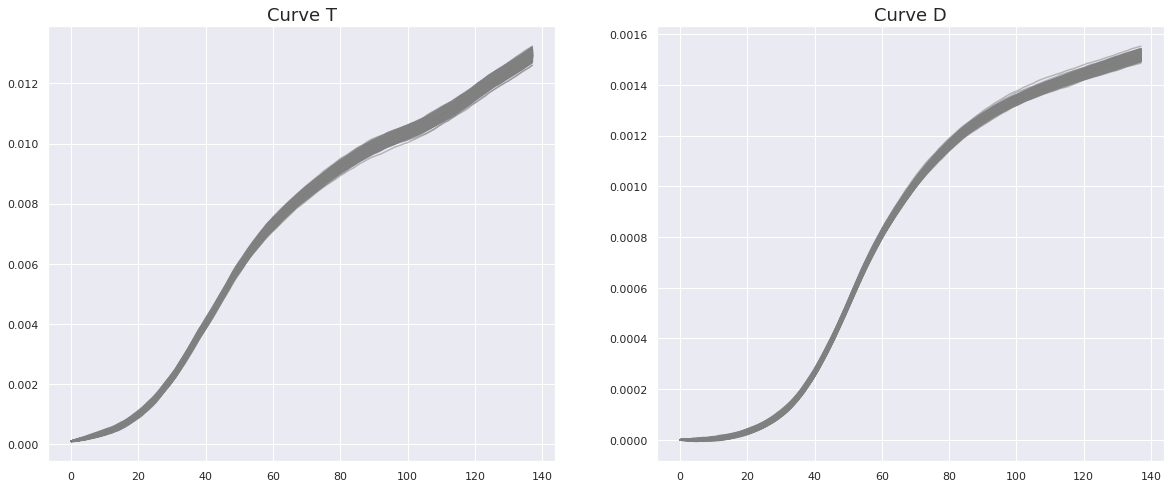

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
ax[0].set_title('Curve T', fontsize = 18)
ax[1].set_title('Curve D', fontsize = 18)
ax[0].plot(T, color = 'red')
ax[1].plot(D, color = 'red')
for seed in experiments.seed:
    ro = np.random.RandomState(seed = seed)
    T_new = generate_curve(T, experiments.sigmaT[0], ro)
    ax[0].plot(T_new, color = 'grey', alpha = 0.5)
    D_new = generate_curve(D, experiments.sigmaD[0], ro)
    ax[1].plot(D_new, color = 'grey', alpha = 0.5)
plt.show()

## Curvas estimadas

Nessa parte, podemos fazer as curvas estimadas a partir dos parâmetros estimados em cada simulação. Primeiro definimos os parâmetros e a curva inicial.

In [7]:
tau    = 1/3.69
omega  = 1/5.74
sigma  = 1/(1/omega - 1/tau)
rho    = 1e-5
delta  = 0.01
gamma1 = 1/7.5
gamma2 = 1/13.4

p = [tau, sigma, rho, delta, gamma1, gamma2]

time_varying = {'beta': {'coefficients':  4, 'bspline_order': 2}, 
            'mu'  : {'coefficients': 4, 'bspline_order': 1}}

initial_day = '2020-03-16'
final_day = '2020-07-31'

init_cond = {'x0': [0.8, 0.3, 5e-7, 5e-7, 5e-7], 
            'bounds': [(0.5,1), (0,1), (1e-7, 5e-5), (1e-7, 5e-5), (1e-7, 5e-5)]}
hmax = 0.2

model = Fitting(p, time_varying, initial_day, final_day, hmax, init_cond)

Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!


Depois podemos integrar as curvas com os parâmetros

In [8]:
alpha_values = list(experiments.alpha)
beta_values = list(experiments.beta)
mu_values = list(experiments.mu)

rt_values = np.zeros((len(alpha_values), model.tf))
beta_curves = np.zeros((len(alpha_values), model.tf))
mu_curves = np.zeros((len(alpha_values), model.tf))

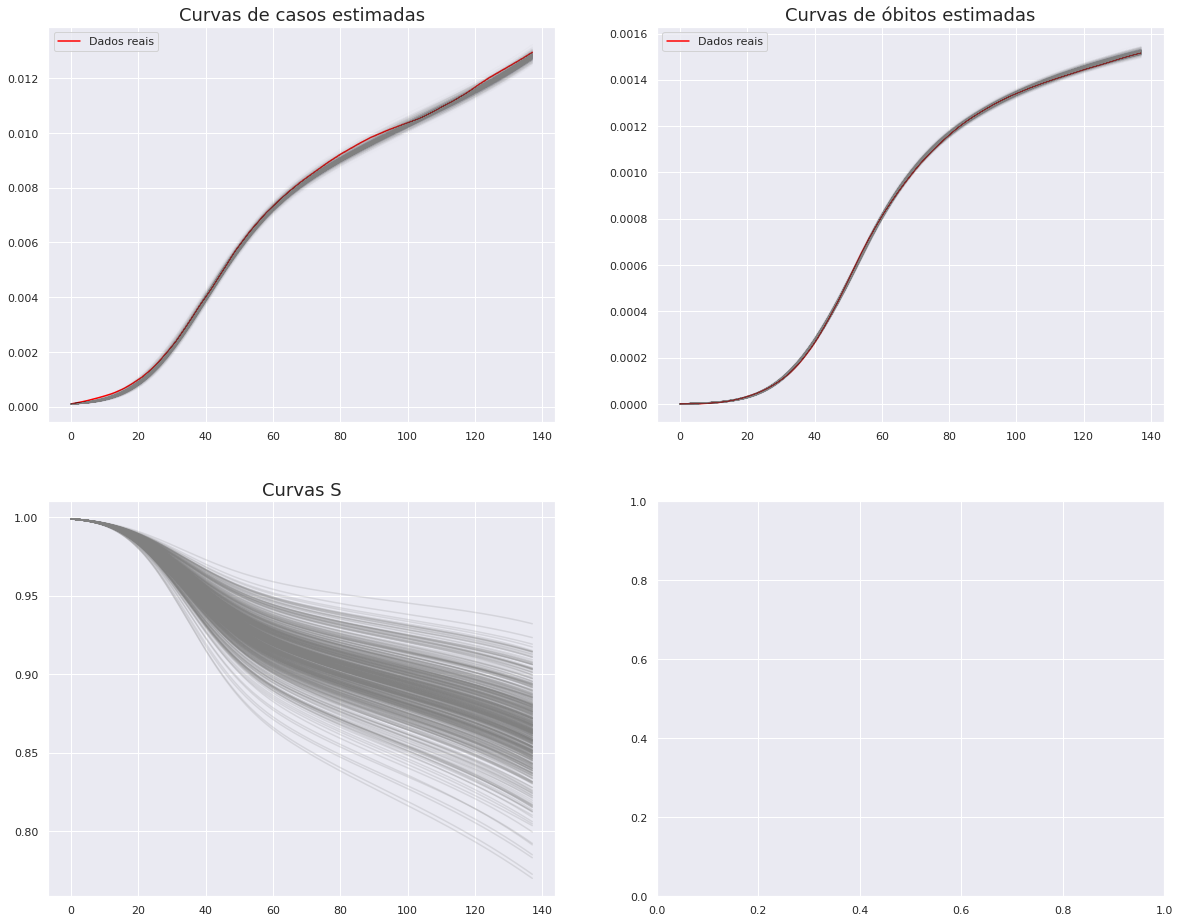

In [9]:
fig, ax = plt.subplots(2, 2, figsize = (20,16))
ax[0][0].set_title('Curvas de casos estimadas', fontsize = 18)
ax[0][1].set_title('Curvas de óbitos estimadas', fontsize = 18)
ax[1][0].set_title('Curvas S', fontsize = 18)
ax[0][0].plot(T, color = 'red', label = 'Dados reais')
ax[0][1].plot(D, color = 'red', label = 'Dados reais')

for i in range(len(alpha_values)):
    
    theta = np.array([alpha_values[i], *beta_values[i], *mu_values[i]])
    
    model.states = model.integrate(theta, p)
    S_hat = model.states[:,4]
    T_hat = model.states[:,7]
    D_hat = model.states[:,6]
    rt_values[i,:] = model.rt_calculation(theta)[1,:]
    beta_curves[i,:] = model.beta(range(model.tf))
    mu_curves[i,:] = model.mu(range(model.tf))
    
    ax[0][0].plot(T_hat, color = 'grey', alpha = 0.01)
    ax[0][1].plot(D_hat, color = 'grey', alpha = 0.01)
    ax[1][0].plot(S_hat, color = 'grey', alpha = 0.2)

ax[0][0].legend()
ax[0][1].legend()

## Intervalos de confiança para $\mathcal{R}_t$ 

In [10]:
lower_quantile_rt = np.quantile(rt_values, q = 0.025, axis = 0)
upper_quantile_rt = np.quantile(rt_values, q = 0.975, axis = 0)
median_rt = np.quantile(rt_values, q = 0.5, axis = 0)

In [11]:
days = [pd.to_datetime(initial_day) + pd.to_timedelta(str(i) +' day') 
        for i in range(model.tf)]

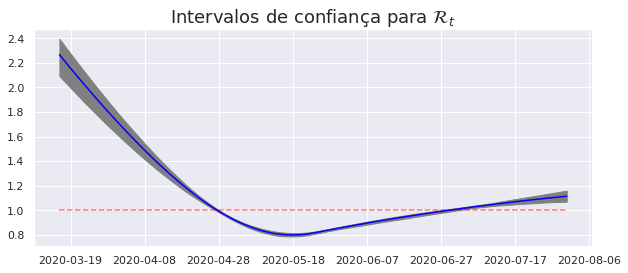

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax.plot(days, median_rt, color = 'blue')
ax.fill_between(x = days, 
                y1 = lower_quantile_rt, y2 = upper_quantile_rt, 
                color = "grey")

ax.hlines(xmin = initial_day, xmax = final_day, y = 1, linestyle = '--', color = 'red', alpha = 0.5)
ax.set_title('Intervalos de confiança para $\mathcal{R}_t$', fontsize = 18)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.savefig('../images/rt_confidence_interval.png', bbox_inches = 'tight', dpi = 400)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


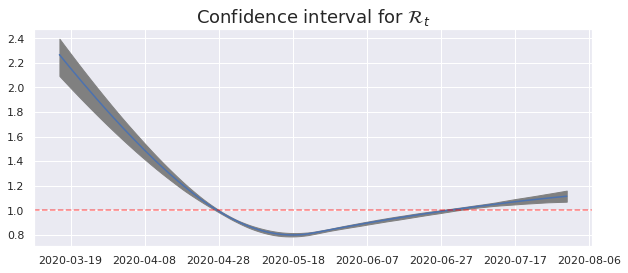

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax.plot(days, median_rt)
ax.fill_between(x = days, 
                y1 = lower_quantile_rt, y2 = upper_quantile_rt, 
                color = "grey")

ax.axhline(y = 1, linestyle = '--', color = 'red', alpha = 0.5)
ax.set_title('Confidence interval for $\mathcal{R}_t$', fontsize = 18)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.savefig('../images/rt_confidence_interval.eps', bbox_inches = 'tight')
plt.show()

## Intervalos de confiança para os parâmetros

In [24]:
lower_quantile_beta = np.quantile(beta_curves, q = 0.025, axis = 0)
upper_quantile_beta = np.quantile(beta_curves, q = 0.975, axis = 0)
median_beta = np.quantile(beta_curves, q = 0.5, axis = 0)

lower_quantile_mu = np.quantile(mu_curves, q = 0.025, axis = 0)
upper_quantile_mu = np.quantile(mu_curves, q = 0.975, axis = 0)
median_mu = np.quantile(mu_curves, q = 0.5, axis = 0)

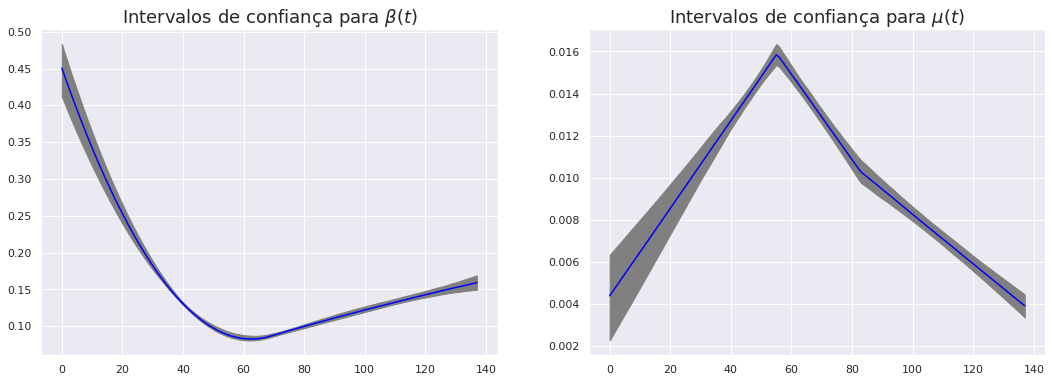

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (18,6))

ax[0].plot(median_beta, color = 'blue')
ax[0].fill_between(x = range(model.tf), 
                   y1 = lower_quantile_beta, y2 = upper_quantile_beta, 
                   color = "grey")
ax[0].set_title(r'Intervalos de confiança para $\beta(t)$', fontsize = 18)

ax[1].plot(median_mu, color = 'blue')
ax[1].fill_between(x = range(model.tf), 
                   y1 = lower_quantile_mu, y2 = upper_quantile_mu, 
                   color = "grey")
ax[1].set_title(r'Intervalos de confiança para $\mu(t)$', fontsize = 18)

plt.show()

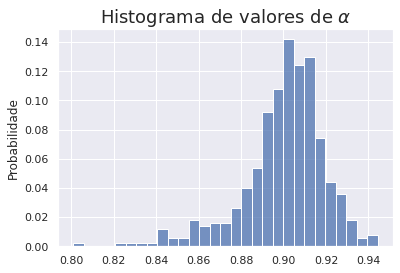

In [26]:
ax = sns.histplot(data = alpha_values, stat = "probability")
ax.set_title(r'Histograma de valores de $\alpha$', fontsize = 18)
ax.set_ylabel("Probabilidade")
plt.show()

In [27]:
np.quantile(alpha_values, q = [0.025, 0.5, 0.975])

array([0.84880866, 0.90315269, 0.93077638])

In [28]:
np.mean(alpha_values)

0.900101209738823

In [29]:
np.quantile(beta_values, q = [0.025, 0.5, 0.975], axis = 0)

array([[0.14229595, 0.06913466, 0.09780451, 0.12305427],
       [0.14428409, 0.07259916, 0.10081468, 0.12621921],
       [0.14719597, 0.07919899, 0.10449178, 0.13151947]])

In [30]:
np.mean(beta_values, axis = 0)

array([0.14445669, 0.07292717, 0.10084174, 0.12641509])

In [31]:
np.quantile(mu_values, q = [0.025, 0.5, 0.975], axis = 0)

array([[0.00924694, 0.01539341, 0.00976152, 0.00672927],
       [0.01013017, 0.01588224, 0.01028924, 0.00702632],
       [0.0110096 , 0.01639806, 0.01084947, 0.00738239]])

In [32]:
np.mean(mu_values, axis = 0)

array([0.01012287, 0.01588215, 0.01028396, 0.00703569])

## Correlação dos parâmetros

Nessa seção, visualizaremos a relação gráfica de como se relacionam as estimativas dos parâmetros. 

In [33]:
correlation = pd.DataFrame(experiments[["alpha", "beta", "mu"]])
correlation.rename(columns = {"alpha": r"$\alpha$"}, inplace = True)
for i in range(4): 
    correlation[r"$\beta_"+str(i+1)+"$"] = list(correlation.beta.apply(lambda x: x[i]))
    correlation[r"$\mu_"+str(i+1)+"$"] = correlation.mu.apply(lambda x: x[i])
correlation.drop(["beta", "mu"], axis = 1, inplace = True)

In [34]:
correlation.columns

Index(['$\alpha$', '$\beta_1$', '$\mu_1$', '$\beta_2$', '$\mu_2$', '$\beta_3$',
       '$\mu_3$', '$\beta_4$', '$\mu_4$'],
      dtype='object')

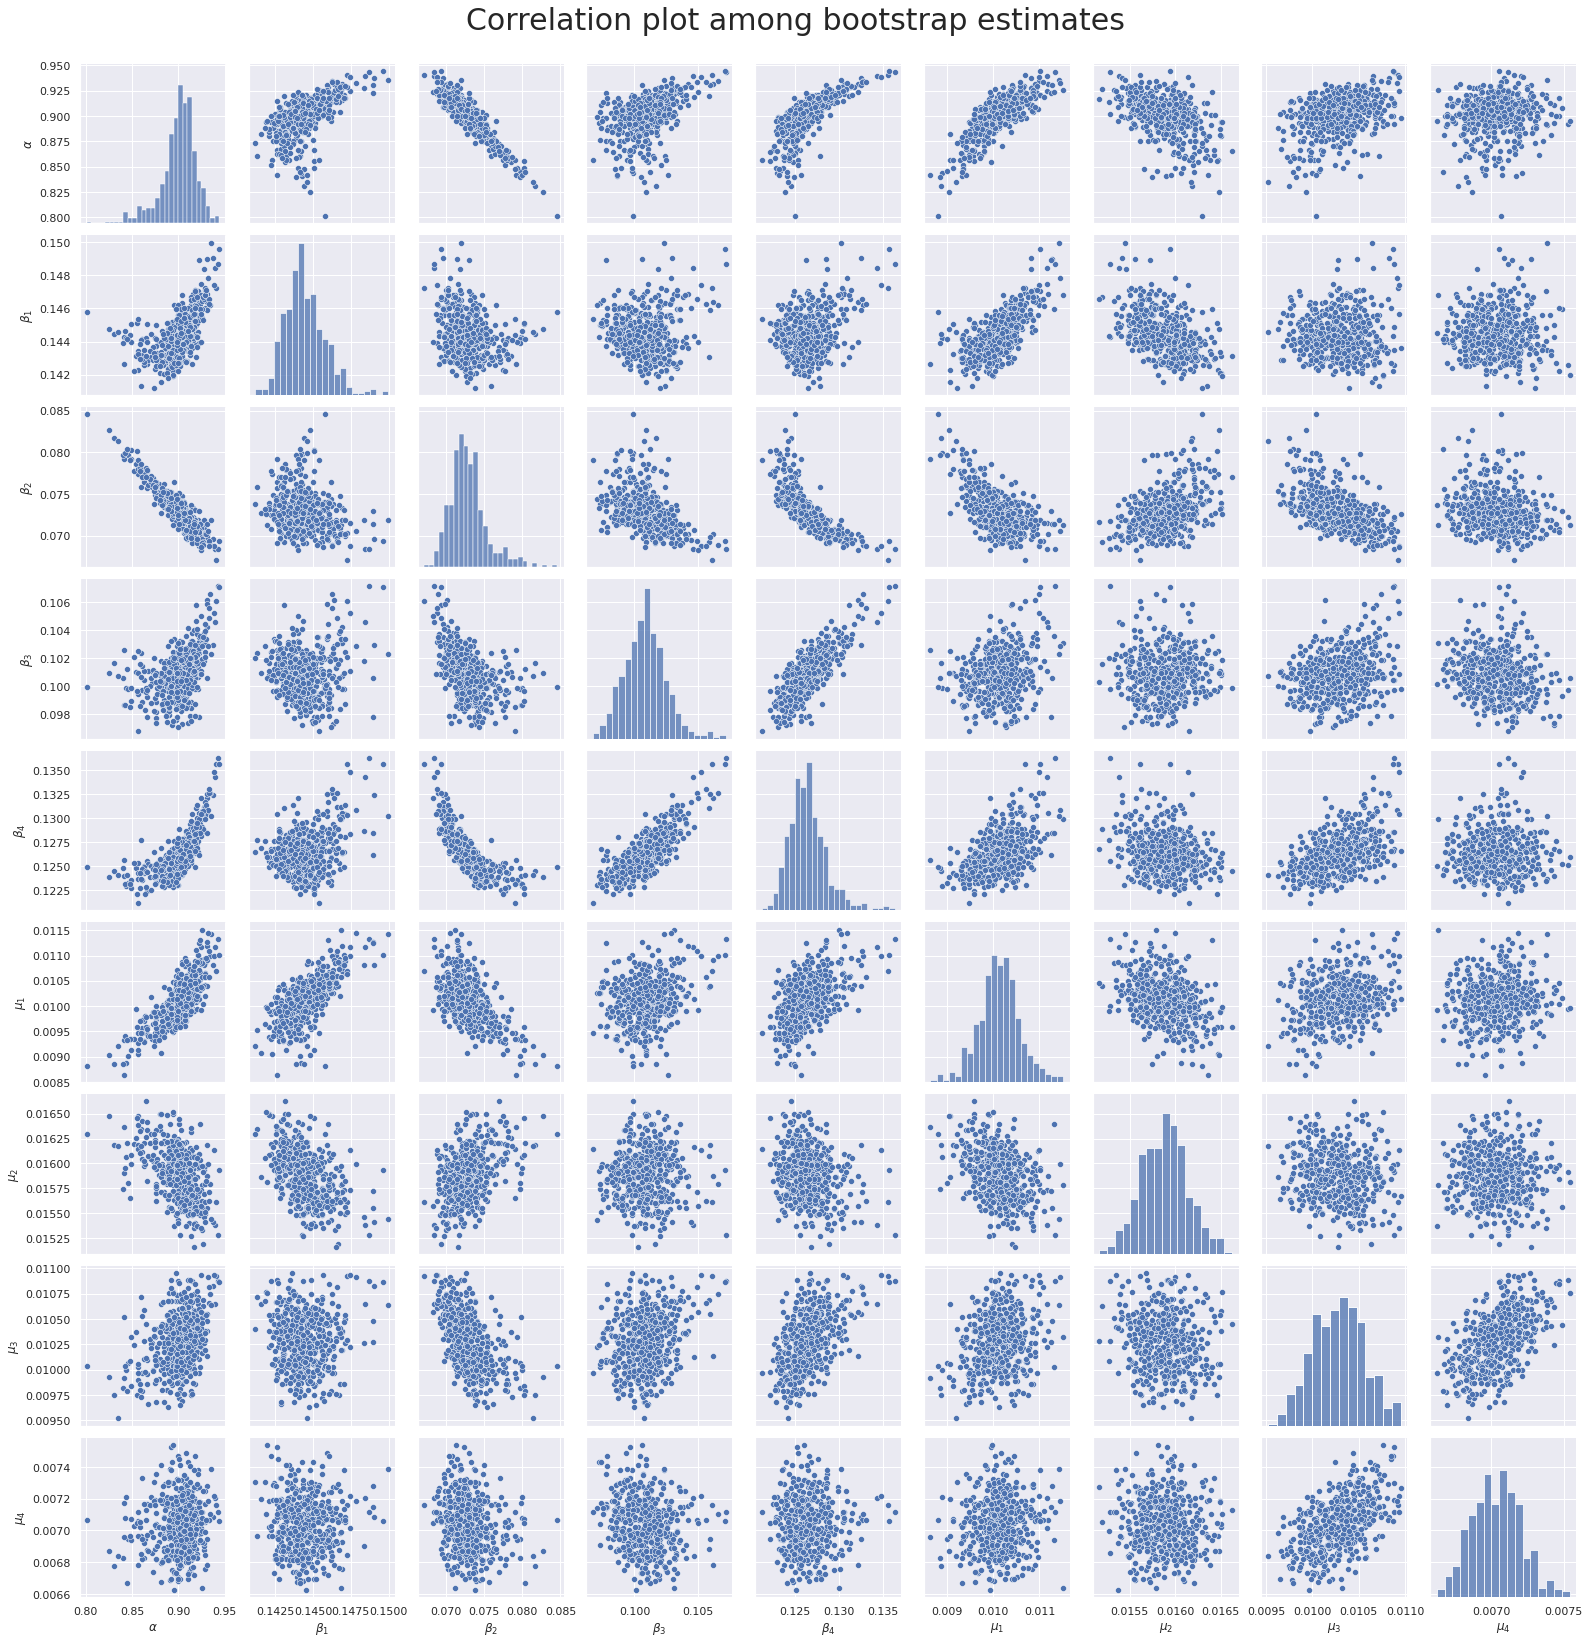

In [40]:
ax = sns.pairplot(correlation, 
                  vars = [r'$\alpha$', r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\beta_4$', 
                          r'$\mu_1$', r'$\mu_2$', r'$\mu_3$',  r'$\mu_4$'])
ax.fig.suptitle('Correlation plot among bootstrap estimates', fontsize = 30, y=1.02)
#plt.savefig("../images/correlation_bootstrap.eps", bbox_inches = "tight")
plt.show()

## Erro médio

In [24]:
np.mean(experiments.obj)

4.443488687651561e-06